- [ ] Import data
- [ ] Make into binary, based on a threshold
- [ ] Find the brighest row and column, i.e. the galaxu of our pixture. Might be able to use blob from skimage
- [ ] Rotate using some sort of PC(A?) to make it easier for our model to handle later. 
- [ ] Resise somewhere along this list to a format we choose. 

# preprocesing
- [ ] Check each image and check how many "blobs" they have. 
- [ ] Remove them 
- [ ] Check how many we have left.  

# Remove images where blob overlap 
- [ ] Check the rows we get in blob
- [ ] Using the middle point and a radius, if two blobs overlap
- [ ] We remove that image. 

In [16]:
%matplotlib inline

In [17]:
import skimage as ski
import numpy as np
import os 
import sys
import matplotlib.pyplot as plt

In [18]:
def get_image_path(galaxyID, test_true=False, train_true=False):
    if galaxyID is None:
        return None
    if isinstance(galaxyID, int):
        galaxyID = str(galaxyID)
    # Get the current working directory
    current_dir = os.getcwd()
    # Search through the subfolders for the image with the same ID
    search_dir = current_dir
    for root, dirs, files in os.walk(search_dir):
        for file in files:
            if file.startswith(galaxyID):
                return os.path.join(root, file)

    # If the image is not found, return None
    return None


In [19]:
# get_image_path(747207)

In [20]:


# img = ski.io.imread(get_image_path(747207))
# img = ski.io.imread(get_image_path(262909))
# img = ski.io.imread(get_image_path(312941)) ##outlier, don't change
# img = ski.io.imread(get_image_path(732356))
# img = ski.io.imread(get_image_path(101151)) ##irregular
# img = ski.io.imread(get_image_path(458590)) ## long
# img = ski.io.imread(get_image_path(459014)) ##overlap
# img = ski.io.imread(get_image_path(856044)) ##overlap
# img = ski.io.imread(get_image_path(856535)) ##overlap
# img = ski.io.imread(get_image_path(100295)) ##black stripe
# img = ski.io.imread(get_image_path(856758)) ##black stripe
# img = ski.io.imread(get_image_path(775905)) ##very inactive galaxy
# img = ski.io.imread(get_image_path(744265)) ##very bright background
# img = ski.io.imread(get_image_path(100008))


In [21]:
# print("Hello")
# raise SystemExit
# image_collection = ski.io.imread_collection('/images_training_rev1/*.jpg', conserve_memory=True)
# print("This should not run")

In [22]:
class Galaxy:
    def __init__(self, x, y, sigma):
        self._x = x
        self._y = y
        self._sigma = sigma
    
    @property
    def center(self):
        return [self._x, self._y]
    
    @property
    def radius(self):
        factor = np.sqrt(2)
        return factor*self._sigma

def cropp_image(image, center_x, center_y, radius):
    return image[int(center_x-radius):int(center_x+radius), int(center_y-radius):int(center_y+radius)]

def overlap(image, galaxy1:Galaxy, galaxy2:Galaxy, verbose=False):
    top_galaxy, bottom_galaxy = (galaxy1, galaxy2) if galaxy1.center[1] > galaxy2.center[1] else (galaxy2, galaxy1) 
    # top_galaxy will be the one most to the bottom of the pictures
    # This is because of the pixel coordinates, where the y-axis is inverted
    
    D = np.sqrt((top_galaxy.center[0]-bottom_galaxy.center[0])**2 + (top_galaxy.center[1]-bottom_galaxy.center[1])**2)
    alpha = np.arcsin((top_galaxy.center[0]-bottom_galaxy.center[0])/D)

    if top_galaxy.center[0] < bottom_galaxy.center[0]:
        alpha = np.pi/2+alpha
    else:
        alpha = np.pi/2+alpha

    closest_point = [int(top_galaxy.center[0] + top_galaxy.radius*np.cos(alpha)), int(top_galaxy.center[1] - top_galaxy.radius*np.sin(alpha))]
    if verbose:
        print(f"Closest point: {closest_point}")
        print(f"Distance: {D}")
        print(f"Alpha: {alpha/np.pi*180} degrees")
        print(f"Top Galaxy center: {top_galaxy.center}")
        print(f"Bottom Galaxy center: {bottom_galaxy.center}")

        #plot the two galaxies
        ski.io.imshow(image)
        plt.plot(top_galaxy.center[0], top_galaxy.center[1], 'go')
        plt.plot(bottom_galaxy.center[0], bottom_galaxy.center[1], 'go')
        #plot the closest point onto the image
   
        plt.plot(closest_point[0], closest_point[1], 'ro')
        
        plt.plot([top_galaxy.center[0], bottom_galaxy.center[0]], [top_galaxy.center[1], bottom_galaxy.center[1]], 'r-')
        plt.show()
    if np.sqrt((closest_point[0]-bottom_galaxy.center[0])**2 + (closest_point[1]-bottom_galaxy.center[1])**2) < bottom_galaxy.radius:
        return True
    else:
        return False

def find_galaxy(image, window, verbose=False):
    blobs = ski.feature.blob_doh(image,
                                threshold=0.004, 
                                max_sigma = 100,
                                overlap=1)
    if verbose:
        print(blobs)
    image_center = [image.shape[0]//2, image.shape[1]//2]
    found_galaxy = None
    largest_sigma = 0
    blobs_in_window = []
    for b in blobs:
        if all(abs(b[i] - image_center[i]) < window for i in range(2)) and b[2] > largest_sigma:
            blobs_in_window.append(b)
            largest_sigma = b[2]
            found_galaxy = b

    if found_galaxy is None:
        return None
        
    found_galaxy = Galaxy(found_galaxy[1], found_galaxy[0], found_galaxy[2])

    for b in blobs:
        blob = Galaxy(b[1], b[0], b[2])
        if blob.center != found_galaxy.center:
            # Check if they overlap
            if overlap(image, found_galaxy, blob, verbose=verbose):
                if verbose:
                    print(f"There is overlap between {found_galaxy.center} and {blob.center}")
                return False
    return found_galaxy
            

In [23]:
def check_for_black_stripe(image, verbose=False):
    # If there is at least 10 dark pixels in a row of any angle that are surrounded by light pixels, then there is a black stripe
    # image is cropped and gray scaled

    dark_pixel_threshold = 0.1
    dark_pixel_count_threshold = 15
    bright_pixel_threshold = 0.2

    dark_pixels = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] < dark_pixel_threshold:
                dark_pixels.append([i,j])
    
    bright_pixels = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] > bright_pixel_threshold:
                bright_pixels.append([i,j])


    suspicious_pixels = []
    # Look at a window around each dark pixel
    # If the mean of the pixels in the window is above the bright pixel threshold, add it to the list of suspicious pixels
    for pixel in dark_pixels:
        window = 5
        window_pixels = []
        for i in range(pixel[0]-window, pixel[0]+window):
            for j in range(pixel[1]-window, pixel[1]+window):
                if i >= 0 and i < image.shape[0] and j >= 0 and j < image.shape[1]:
                    window_pixels.append(image[i][j])
        if np.mean(window_pixels) > bright_pixel_threshold:
            suspicious_pixels.append(pixel)

    #Plot the dark pixels onto the image
    if verbose:
        ski.io.imshow(image)
        
        for pixel in bright_pixels:
            plt.plot(pixel[1], pixel[0], 'bo')
        for pixel in dark_pixels:
            plt.plot(pixel[1], pixel[0], 'ro')
        for pixel in suspicious_pixels:
            plt.plot(pixel[1], pixel[0], 'go')
        plt.show()

    # How many suspicious pixels are there?
    if len(suspicious_pixels) > dark_pixel_count_threshold:
        # Do linear regression on the suspicious pixels
        # If the R^2 value is high, then there is a black stripe

        # Get the x and y values of the suspicious pixels
        x = []
        y = []
        for pixel in suspicious_pixels:
            x.append(pixel[0])
            y.append(pixel[1])
        # Do linear regression with numpy
        slope, intercept = np.polyfit(x, y, 1)
        #Plot the line
        if verbose:
            plt.plot(x, y, 'ro')
            plt.plot(x, [slope*x[i] + intercept for i in range(len(x))], 'b')
            plt.show()
        # Get the R^2 value
        r_squared = np.corrcoef(x, y)[0,1]**2
        # If the R^2 value is high, then there is a black stripe
        print(f"R^2 = {r_squared}")
        if r_squared > 0.7:
            print("Black Stripe found")
            return True
        else:
            print("Black Stripe was not found")
            return False
    else:
        return False

In [24]:
def get_covariance_matrix(image, x_size, y_size):
    coord_rows = []
    coord_columns = []
    for index_row in range(0, x_size):
        for index_column in range(0, y_size):
            if image[index_row][index_column] == 1:
                coord_rows.append(index_row)
                coord_columns.append(index_column)
    cov_matrix = np.cov(coord_rows, y=coord_columns)
    return cov_matrix


In [25]:
def get_rotation_on_image(image, verbose=False):
    binary_image = ski.util.img_as_bool(image)
    if verbose:
        ski.io.imshow(binary_image)
        pass
    
    cov_matrix = get_covariance_matrix(binary_image, len(binary_image), len(binary_image[0]))
    
    if verbose:
        print(f"cov_matrix[0] = \t[{cov_matrix[0][0]}, {cov_matrix[0][1]}]")
        print(f"cov_matrix[1] = \t[{cov_matrix[1][0]}, {cov_matrix[1][1]}]")
    result = np.linalg.eigh(cov_matrix)
    eigenvalues = result[0]
    eigenvectors = result[1]

    
    max_eigen_index, = np.where(np.isclose(eigenvalues, max(eigenvalues)))[0]
    if verbose:
        print(f"Eigenvalues     = \t[{eigenvalues[0]}, {eigenvalues[1]}]")
        print(f"eigenvectors[0] = \t[{eigenvectors[0][0]}, {eigenvectors[0][1]}]")
        print(f"eigenvectors[1] = \t[{eigenvectors[1][0]}, {eigenvectors[1][1]}]")
        print(eigenvectors[max_eigen_index][0])
        print(eigenvectors[(max_eigen_index+1)%2][1])
    rotations_in_radians = np.arccos((eigenvectors[max_eigen_index][0]+eigenvectors[(max_eigen_index+1)%2][1]) / 2)
    rotation_in_degrees = np.rad2deg(rotations_in_radians)
    if rotation_in_degrees > 90:
        rotation_in_degrees = 180 - rotation_in_degrees


    if (eigenvectors[max_eigen_index][0] * eigenvectors[max_eigen_index][1]) > 0:
        rotation_in_degrees = -rotation_in_degrees

    if verbose:
        print("Rotating images with the deg", rotation_in_degrees)
        # ski.io.imshow(ski.transform.rotate(image, rotation_in_degrees))

    return rotation_in_degrees+90


In [26]:
def filter_image(img, verbose=False):
    """
    Very simple function that is only supposed to use already existing functions with minimal interaction to handle a picture.
    
    It should return true if it's filtered out and false if it's not.
    """
    gray_img = ski.color.rgb2gray(img)
    galaxy = find_galaxy(gray_img, window=50, verbose=verbose) 
    if galaxy is None or galaxy is False:
        return True
    
    cropped_img = cropp_image(gray_img, galaxy.center[0], galaxy.center[1], galaxy.radius)
    cropped_exposed_img = ski.exposure.rescale_intensity(cropped_img)
    return_value = check_for_black_stripe(cropped_exposed_img, verbose=verbose) ## Not implemented
    if return_value is True:
        return True
        
    return galaxy

def preprocess_image(img, galaxy, verbose=False):
    """
    Function that should handle the image and return a cropped and rotated image.
    """  
    gray_img = ski.color.rgb2gray(img)  
    cropped_img = cropp_image(gray_img, galaxy.center[0], galaxy.center[1], galaxy.radius)
    cropped_exposed_img = ski.exposure.rescale_intensity(cropped_img)
    angle = get_rotation_on_image(cropped_exposed_img, verbose=verbose)
    rotated_image = ski.transform.rotate(gray_img, angle)
    cropped_rotated_img = cropp_image(rotated_image, galaxy.center[0], galaxy.center[1], galaxy.radius)
    resized_cropped_rotated_image = ski.transform.resize(cropped_rotated_img, (128, 128))
    resized_cropped_rotated_image = ski.exposure.rescale_intensity(resized_cropped_rotated_image)
    return resized_cropped_rotated_image


Image[0] = 976602
Image[0]
Image passed filter
Image was preprocessed
Image[1] = 976607
Image[1]
Image passed filter
Image was preprocessed
Image[2] = 976620
Image[2]
Image[2] was filtered out
Image[3] = 976623
Image[3]


/opt/conda/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:162: UserWarning: The figure layout has changed to tight
  ax.get_figure().tight_layout()


Image passed filter
Image was preprocessed
Image[4] = 976632
Image[4]
Image passed filter
Image was preprocessed
Image[5] = 976634
Image[5]
Image passed filter
Image was preprocessed
Image[6] = 976637
Image[6]
Image passed filter
Image was preprocessed
Image[7] = 976669
Image[7]
Image passed filter
Image was preprocessed
Image[8] = 976672
Image[8]
Image[8] was filtered out
Image[9] = 976703
Image[9]
Image passed filter
Image was preprocessed
Image[10] = 976707
Image[10]
Image passed filter
Image was preprocessed
Image[11] = 976713
Image[11]
Image passed filter
Image was preprocessed
Image[12] = 976725
Image[12]
Image passed filter
Image was preprocessed


KeyboardInterrupt: 

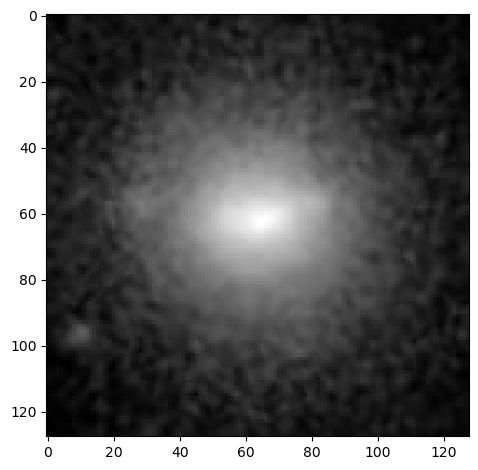

In [27]:
# FLAGS 
FILTER_IMAGES = True
PREPROCESS_IMAGES = True
VERBOSE = True
VERBOSE_FUNCTIONS = False
# Check if the folder, images_training_subfolder31, exists
FOLDER_OF_INTEREST = "images_training_subfolder31"

if not os.path.isdir(FOLDER_OF_INTEREST):
    print(f"The folder {FOLDER_OF_INTEREST} does not exist. Please download from the Kaggle website and split if needed.")
    raise SystemExit

image_collection = ski.io.imread_collection(f"./{FOLDER_OF_INTEREST}/*.jpg", conserve_memory=True)

for index, image in enumerate(image_collection):
    name = image_collection.files[index].split("/")[-1].split(".")[0]
    
    if VERBOSE:
        print(f"Image[{index}]")

    if FILTER_IMAGES:
        return_value = filter_image(image, VERBOSE_FUNCTIONS) 
        if return_value is True:
            if VERBOSE:
                print(f"Image[{index}] was filtered out")
            continue 
    galaxy = return_value
    
    if VERBOSE:
        print("Image passed filter")

    if PREPROCESS_IMAGES:
        preprocessed_image = preprocess_image(image, galaxy, VERBOSE_FUNCTIONS)
        # Send image to prepped_images folder
        # Make it a tiff file
        image = ski.img_as_ubyte(preprocessed_image)
        # If the folder does not exist, create it
        if not os.path.isdir(f"./prepped_images/{FOLDER_OF_INTEREST}"):
            os.mkdir(f"./prepped_images/{FOLDER_OF_INTEREST}")
        ski.io.imsave(f"./prepped_images/{FOLDER_OF_INTEREST}/{name}.tiff", image)

    if VERBOSE:
        print("Image was preprocessed")

        ski.io.imshow(preprocessed_image)
   


In [ ]:
print("Hello")
raise SystemExit
print("This should not run")

# Here are some testing

[[ 6  4  3 ...  3  5  5]
 [ 8  6  4 ...  3  4  5]
 [ 9  7  7 ...  2  4  5]
 ...
 [20 17 12 ...  4  5  6]
 [17 15 12 ...  3  3  4]
 [14 13 12 ...  3  3  3]]


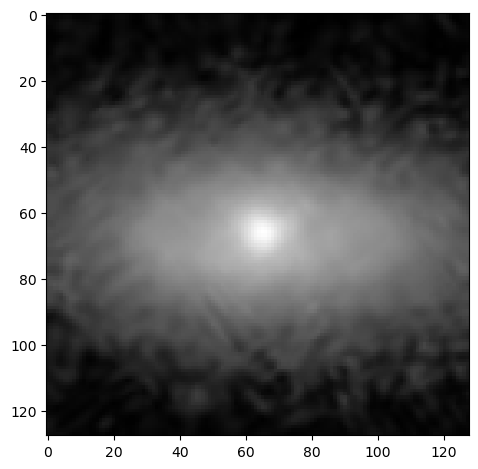

In [ ]:
#Testing
img = ski.io.imread('prepped_images/images_training_subfolder31/156.tiff')
print(np.array(img))
ski.io.imshow(img)

In [ ]:
import 